<a href="https://colab.research.google.com/github/BecomeAllan/RNN/blob/main/Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratório

## Implementações com RNNs

# O que é uma RNN ?

Uma Recurrent neural network (RNN) é uma arquitetura de Rede Neural que processa dados sequenciais, como palavra por palavra em uma frase ou informações através do tempo.

Algo notável na RNN é a capacidade de processar sequências independente do tamanho do vetor de entrada, não precisando ter um tamanho fixo para poder rodar a rede. Por exemplo, uma única rede poderia processar frases com 3, 5, 10 ou mais palavras na mesma rede.

Algumas aplicações são mostradas na imagem a seguir, no qual a *one to one* seria uma rede do tipo *FeedFoward*.


![image](https://raw.githubusercontent.com/BecomeAllan/RNN/main/images/Aquitetura.png)

[Imagem retirada daqui](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)


# Comportamento de uma RNN

O comportamento de uma célula padrão de RNN é através de um loop, onde o $x_t$ é o input confome o tempo $t$ e está célula representada por $h_t$ transporta a informação para a próxima $h_{t+1}$ com a informação adicional para atualizar junto com o $x_{t+1}$.

O comportamento de um estado de célula $h_t$ diz conforme a próxima informação vai ser processada, criando uma correlação do estado passado para o presente $t$.

<img src="https://raw.githubusercontent.com/BecomeAllan/RNN/main/images/Esquelto.png" alt="rnn" width="700"/>


<img src="https://raw.githubusercontent.com/BecomeAllan/RNN/main/images/Feedfoward.png" alt="rnn" width="700"/>

[Imagens retiradas daqui](http://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L2.pdf)

## Pseudo-código de uma célula RNN

Queremos que a célula de RNN complete a frase:
+ "I love recurrent neural"

prevendo na última interação a palavra:
+ "network".

In [ ]:
rnn_cell = RNN()

# Inicial h_t
hidden_state = [0,0,0,0]

X_t = ['I', 'love', 'recurrent', 'neural'] ## input [x_1, x_2, x_3, x_4 ] output da Y_4 = ['network']

for word in X_t:
  y_hat, hidden_state = rnn_cell(word, hidden_state)

# ['network']
next_word_predict = y_hat

## Pseudo-código de uma célula RNN para amantes do KERAS

In [ ]:
# Bibliotecas usadas
import tensorflow as tf
from tensorflow import keras
import numpy as np
    
dot = tf.matmul
   
# Criando a layer RNN
class RNN_cell(keras.layers.Layer):
  def __init__(self, rnn_units, input_dim, output_dim):
    super(RNN_cell, self).__init__()

    # Pesos
    self.W_xh = self.add_weight(shape = (rnn_units, input_dim), initializer="random_normal", dtype='float32')
    self.W_hh = self.add_weight(shape = (rnn_units, rnn_units), initializer="random_normal", dtype='float32')
    self.W_hy = self.add_weight(shape = (output_dim, rnn_units), initializer="random_normal", dtype='float32')

    # Estado (h_0) inicial 
    self.h = tf.zeros([rnn_units, 1])
  
  def call(self, x):
    # x -> h
    # Atualiza o estado h_t
    self.h = tf.tanh( dot(self.W_hh, self.h) + dot( self.W_xh, x))

    # h -> y
    # 'Dense'
    predict = dot( self.W_hy, self.h)
    return predict

  def get_config(self):
    return {"W_xh": self.W_xh.numpy(),
            "W_hh": self.W_hh.numpy(),
            "W_hy": self.W_hy.numpy(),
            "h": self.h.numpy()}


# Constantes
RNN_UNITS = 2
INPUT_DIM = 2
OUTPUT_DIM = 1



x = np.array([[1,3,5,7,9],
              [2,4,6,8,10]], dtype='float32')
print(f'Shape do input: {x.shape}')

hidden = RNN_cell(RNN_UNITS, INPUT_DIM, OUTPUT_DIM)

temp = x.shape[1]

config = hidden.get_config()
####
print(f"Pesos: \n W_xh:\n{config['W_xh']}\n\n W_hh:\n{config['W_hh']}\n\n W_hy:\n{config['W_hy']}\n\n h:\n{config['h']}")

In [ ]:
print(f'rnn_units: {RNN_UNITS} | input_dim: {INPUT_DIM} | output_dim: {OUTPUT_DIM} |  Número de sequencias: {temp}')
print(f"Input: \n {x}\n")
for t in range(0, temp):
  ht = hidden.get_config()
  xt = x[:,t]
  xt = xt.reshape((2,1))
  y_hat = hidden(xt)
  print(f"> Tempo (t):{t} \n> Valor do estado (h):\n{ht['h']} \n> Previu (y_hat): \n{y_hat}")
  print('----\n')

keras.backend.clear_session()

## Quantidade de  células (unidades) de RNN

+ Veja pelo diagrama que não existe conexão entre as unidades de RNN mas apenas entre suas próprias células.

<img src="https://raw.githubusercontent.com/BecomeAllan/RNN/main/images/Units.png" alt="units" width="700"/>

# Quando usar uma RNN ?

Como já introduzido, uma RNN é usada quando os dados tem interação conforme o "tempo" passa, ou melhor dizendo, se suas variáveis de *input* tem uma correlação com as dadas sequências destas.

Ou seja, se uma sequência é passada para uma RNN, como $x_1=[1,2,3]$ e sua "resposta" seria o inverso dela, $y=[3,2,1]$, observa-se que existe uma relação entre a sequência do *input* $x$ que diz muito sobre como será o *output*.

Há muitos outros exemplos que podem ser explorados com RNNs e alguns deles serão abordados por este documento.

Alguns tipos de dados que são usados para utilizar RNNs:
+ **Tipo de dados:** Sequências, One-Hot-Encode...

## Exemplo 1.1: Artificial neural network

Conforme o exemplo da sequência $x_1=[1,2,3]$ e $y=[3,2,1]$, exploramos estes dados com uma rede neural *feedfoward* para avaliar sua resposta.

In [598]:
#@title Funções auxiliares

from random import randint, seed

def sequence(zero_to , n):	
  return [randint(0, zero_to) for _ in range(n)]

def backsequence(seq):
  return seq[::-1]

def one_hot_encode(data, max_lenght):
  new_data = [None]*(len(data))
  c = 0
  for x in data:
    hot = [0]*(max_lenght)
    hot[x] = 1
    new_data[c] = hot
    c = c+1
  return new_data

def one_hot_decode(data):
  return [np.argmax(x) for x in data]


def create_dataset(train_size, test_size, time_steps, vocabulary_size):
  x = [sequence(vocabulary_size - 1 , time_steps) for _ in range(train_size)]
  y = [backsequence(y) for y in x]
  X_train = np.array([one_hot_encode(x, vocabulary_size) for x in x])
  Y_train = np.array([one_hot_encode(y, vocabulary_size) for y in y])
  
  x = [sequence(vocabulary_size - 1 , time_steps) for _ in range(test_size)]
  y = [backsequence(y) for y in x]
  X_test = np.array([one_hot_encode(x, vocabulary_size) for x in x])
  Y_test = np.array([one_hot_encode(y, vocabulary_size) for y in y])

  return X_train, Y_train, X_test, 	Y_test

def plot(p):
	plt.plot(p.history['accuracy'])
	plt.plot(p.history['val_accuracy'])
	plt.title('accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
 
	plt.plot(p.history['loss'])
	plt.plot(p.history['val_loss'])
	plt.title('loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

### Criando o dataset

In [ ]:
# Dados em one-hot-encode
X_train, Y_train, X_test, Y_test = create_dataset(train_size=20000, test_size=200, time_steps=5, vocabulary_size=10)

print(f'Amostra 1:\n\
x = {one_hot_decode(X_train[0])}\n \
one_hot_encode do x:\n \
{X_train[0]}\n\n \
y = {one_hot_decode(Y_train[0])}\n \
one_hot_encode do y:\n \
{Y_train[0]}')

### Modelo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5, 32)             352       
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 32)             128       
_________________________________________________________________
dense_1 (Dense)              (None, 5, 64)             2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 64)             256       
_________________________________________________________________
dense_2 (Dense)              (None, 5, 10)             650       
Total params: 3,498
Trainable params: 3,306
Non-trainable params: 192
_________________________________________________________________


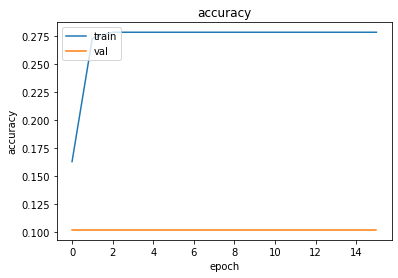

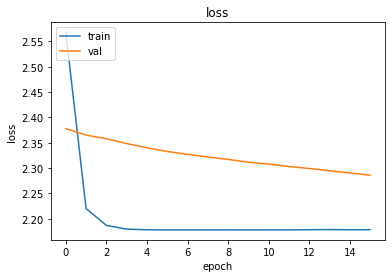

--Algumas previsões---
x:
[[0, 5, 8, 9, 0], [4, 7, 7, 4, 0], [6, 9, 6, 7, 5], [7, 5, 3, 7, 5], [7, 1, 6, 1, 2], [3, 3, 6, 8, 2], [3, 7, 5, 1, 4], [6, 2, 2, 5, 4], [2, 3, 2, 5, 8], [3, 9, 6, 0, 7]]
y_hat:
[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
y:
[[0, 9, 8, 5, 0], [0, 4, 7, 7, 4], [5, 7, 6, 9, 6], [5, 7, 3, 5, 7], [2, 1, 6, 1, 7], [2, 8, 6, 3, 3], [4, 1, 5, 7, 3], [4, 5, 2, 2, 6], [8, 5, 2, 3, 2], [7, 0, 6, 9, 3]]


In [671]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

VOCAB_SIZE = 10
TIME_STEPS = 5

# Modelo RNA feedfoward
modelo = keras.Sequential(
    [
     keras.Input(shape=(TIME_STEPS ,VOCAB_SIZE), name="Input"),
     layers.Dense(32, activation='sigmoid'),
     layers.BatchNormalization(),
     layers.Dense(64, activation='sigmoid'),
     layers.BatchNormalization(),
     layers.Dense(10, activation= "softmax")
    ]
)

modelo.summary()

# Treinando modelo
modelo.compile(optimizer='adam', metrics=['accuracy'], loss= keras.losses.categorical_crossentropy)
hist = modelo.fit(x = X_train,
                  y = Y_train,
                  validation_split=0.2,
                  batch_size = 1000,
                  epochs=200,
                  callbacks=keras.callbacks.EarlyStopping('loss', patience=10),
                  verbose=0)

# Grafico
plot(hist)

# Previsões
y_hat = modelo(X_test[0:10])


x = [one_hot_decode(y) for y in X_test[0:10] ]
y_hat_num = [[np.argmax(y) for y in k] for k in y_hat]
y = [one_hot_decode(y) for y in Y_test[0:10] ]

print("--Algumas previsões---")
print(f'x:\n{x}\ny_hat:\n{y_hat_num}\ny:\n{y}')

keras.backend.clear_session()

### Exemplo 1.2: RNN

Agora, o exemplo vai ser aplicado com uma RNN para avaliar sua capacidade.

### Modelo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 16)                432       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 16)             0         
_________________________________________________________________
dense (Dense)                (None, 5, 10)             170       
Total params: 602
Trainable params: 602
Non-trainable params: 0
_________________________________________________________________


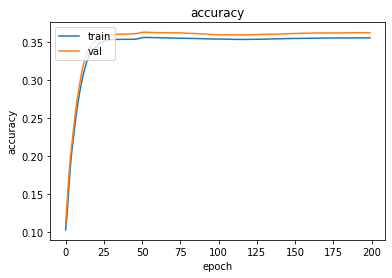

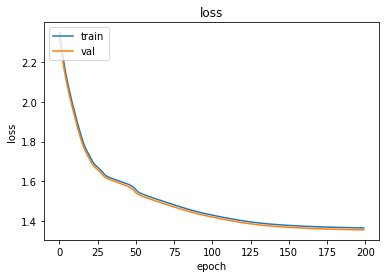

--Algumas previsões---
x:
[[0, 5, 8, 9, 0], [4, 7, 7, 4, 0], [6, 9, 6, 7, 5], [7, 5, 3, 7, 5], [7, 1, 6, 1, 2], [3, 3, 6, 8, 2], [3, 7, 5, 1, 4], [6, 2, 2, 5, 4], [2, 3, 2, 5, 8], [3, 9, 6, 0, 7]]
y_hat:
[[0, 0, 0, 0, 0], [4, 4, 4, 4, 4], [6, 6, 6, 6, 6], [5, 5, 5, 5, 5], [1, 1, 1, 1, 1], [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [2, 2, 2, 2, 2], [2, 2, 2, 2, 2], [6, 6, 6, 6, 6], [4, 4, 4, 4, 4], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [6, 6, 6, 6, 6], [5, 5, 5, 5, 5], [3, 3, 3, 3, 3], [3, 3, 3, 3, 3], [4, 4, 4, 4, 4], [0, 0, 0, 0, 0], [7, 7, 7, 7, 7], [6, 6, 6, 6, 6], [5, 5, 5, 5, 5], [7, 7, 7, 7, 7], [3, 3, 3, 3, 3], [0, 0, 0, 0, 0], [3, 3, 3, 3, 3], [2, 2, 2, 2, 2], [8, 8, 8, 8, 8], [3, 3, 3, 3, 3], [9, 9, 9, 9, 9], [9, 9, 9, 9, 9], [2, 2, 2, 2, 2], [7, 7, 7, 7, 7], [9, 9, 9, 9, 9], [9, 9, 9, 9, 9], [6, 6, 6, 6, 6], [3, 3, 3, 3, 3], [0, 0, 0, 0, 0], [6, 6, 6, 6, 6], [2, 2, 2, 2, 2], [7, 7, 7, 7, 7], [2, 2, 2, 2, 2], [8, 8, 8, 8, 8], [5, 5, 5, 5, 5], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0], [6, 6, 6, 6, 

In [673]:
from tensorflow import keras
from keras import layers

VOCAB_SIZE = 10
TIME_STEPS = 5

# Modelo RNN
modelo = keras.Sequential(
    [
     keras.Input(shape=(TIME_STEPS, VOCAB_SIZE), name="Input"),
     # Output do RNN é o ultimo valor da sequencia
     layers.SimpleRNN(16),
     # Replica o valor do output TIME_STEPS vezes
     layers.RepeatVector(TIME_STEPS),
     layers.Dense(VOCAB_SIZE, activation= "softmax")
    ]
)

modelo.summary()

# Treinando modelo
modelo.compile(optimizer='adam', metrics=['accuracy'], loss= keras.losses.categorical_crossentropy)
hist = modelo.fit(x = X_train,
                  y = Y_train,
                  validation_split=0.2,
                  batch_size = 1000,
                  epochs=200,
                  callbacks=keras.callbacks.EarlyStopping('loss', patience=10),
                  verbose=0)

# Grafico
plot(hist)

# Previsões
y_hat = modelo(X_test)


x = [one_hot_decode(y) for y in X_test[0:10] ]
y_hat_num = [[np.argmax(y) for y in k] for k in y_hat]
y = [one_hot_decode(y) for y in Y_test[0:10] ]

print("--Algumas previsões---")
print(f'x:\n{x}\ny_hat:\n{y_hat_num}\ny:\n{y}')

keras.backend.clear_session()

### Diferentes tamanhos de células de RNN

In [675]:
#@title Funções auxiliares
def rnn_model(unn):
  modelo = keras.Sequential(
      [
       keras.Input(shape=(TIME_STEPS, VOCAB_SIZE), name="Input"),
       # Output do RNN é o ultimo valor da sequencia
       layers.SimpleRNN(unn),
       # Replica o valor do output TIME_STEPS vezes
       layers.RepeatVector(TIME_STEPS),
       layers.Dense(VOCAB_SIZE, activation= "softmax")
     ]
    )
  modelo.compile(optimizer='adam', metrics=['accuracy'],
                 loss= keras.losses.categorical_crossentropy)
  hist = modelo.fit(x = X_train,
                  y = Y_train,
                  validation_split=0.2,
                  batch_size = 1000,
                  epochs=200,
                  callbacks=keras.callbacks.EarlyStopping('loss', patience=10),
                  verbose=0)

  # Previsões
  y_hat = modelo(X_test[0:10])
  y_hat_v = modelo.evaluate(X_test, Y_test, verbose=0)

  x = [one_hot_decode(y) for y in X_test[0:10] ]
  y_hat_num = [[np.argmax(y) for y in k] for k in y_hat]
  y = [one_hot_decode(y) for y in Y_test[0:10] ]

  print(f"Acurácia: {round(y_hat_v[1],2)}")
  print("--Algumas previsões---")
  print(f'x:\n{x}\ny_hat:\n{y_hat_num}\ny:\n{y}')
  keras.backend.clear_session()


In [676]:
## Unidades de RNN
for u in [2,4,16]:
  print(f'Unidades de RNN: {u}')
  rnn_model(u)
  print('\n\n')

Unidades de RNN: 2
Acurácia: 0.21
--Algumas previsões---
x:
[[0, 5, 8, 9, 0], [4, 7, 7, 4, 0], [6, 9, 6, 7, 5], [7, 5, 3, 7, 5], [7, 1, 6, 1, 2], [3, 3, 6, 8, 2], [3, 7, 5, 1, 4], [6, 2, 2, 5, 4], [2, 3, 2, 5, 8], [3, 9, 6, 0, 7]]
y_hat:
[[3, 3, 3, 3, 3], [6, 6, 6, 6, 6], [6, 6, 6, 6, 6], [3, 3, 3, 3, 3], [1, 1, 1, 1, 1], [3, 3, 3, 3, 3], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [2, 2, 2, 2, 2], [8, 8, 8, 8, 8]]
y:
[[0, 9, 8, 5, 0], [0, 4, 7, 7, 4], [5, 7, 6, 9, 6], [5, 7, 3, 5, 7], [2, 1, 6, 1, 7], [2, 8, 6, 3, 3], [4, 1, 5, 7, 3], [4, 5, 2, 2, 6], [8, 5, 2, 3, 2], [7, 0, 6, 9, 3]]



Unidades de RNN: 4
Acurácia: 0.29
--Algumas previsões---
x:
[[0, 5, 8, 9, 0], [4, 7, 7, 4, 0], [6, 9, 6, 7, 5], [7, 5, 3, 7, 5], [7, 1, 6, 1, 2], [3, 3, 6, 8, 2], [3, 7, 5, 1, 4], [6, 2, 2, 5, 4], [2, 3, 2, 5, 8], [3, 9, 6, 0, 7]]
y_hat:
[[5, 5, 5, 5, 5], [4, 4, 4, 4, 4], [9, 9, 9, 9, 9], [0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [8, 8, 8, 8, 8], [3, 3, 3, 3, 3], [5, 5, 5, 5, 5], [2, 2, 2, 2, 2], [7, 7, 7, 7, 7]]
y:
[[

# Aplicações com RNN

Assim como foi visto

In [ ]:
#@title Bibliotecas
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import os
import time
import re

!pip install unidecode
from unidecode import unidecode

tf.config.list_physical_devices('GPU')

## Tratamento de dados

In [ ]:
#@title Baixando os dados
# Baixar dataset
!gdown --id 15FhPHu7Hx6ul_k-EEBZwzpUWznK0gBR3

!gdown --id 1Eq9oi3_1PuSZ5hoZS5M1A5pTMSyy3K_a


In [ ]:
#@title Dados
# Data1
poem_data = pd.read_csv("portuguese-poems.csv", encoding='UTF-8')

# Data2
cript_data = pd.read_csv("Ethereum Historical Data.csv", encoding='UTF-8')

poem_data = poem_data.dropna()
cript_data = cript_data.dropna()

In [683]:
#@title Dados(poem_data): portuguese-poems.csv
poem_data.head()

,Author,Title,Content,Views
0,Cecília Meireles,Retrato,"Eu não tinha este rosto de hoje,\r\nAssim calm...",1018431
1,Fernando Pessoa,"Para ser grande, sê inteiro: nada","Para ser grande, sê inteiro: nada\r\nTeu exage...",1979413
2,Marina Colasanti,"Eu sei, mas não devia",Eu sei que a gente se acostuma. Mas não devia....,301509
3,Carlos Drummond de Andrade,Quadrilha,João amava Teresa que amava Raimundo\r\nque am...,1421206
4,Eugénio de Andrade,É urgente o amor,É urgente o amor.\r\nÉ urgente um barco no mar...,621197


In [684]:
#@title Dados(cript_data): Ethereum Historical Data.csv

cript_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 10, 2016",11.75,11.20,11.85,11.07,0.00K,4.91%
1,"Mar 11, 2016",11.95,11.75,11.95,11.75,0.18K,1.70%
2,"Mar 12, 2016",12.92,11.95,13.45,11.95,0.83K,8.12%
3,"Mar 13, 2016",15.07,12.92,15.07,12.92,1.30K,16.64%
4,"Mar 14, 2016",12.50,15.07,15.07,11.40,92.18K,-17.05%


In [ ]:
data = pd.DataFrame()


Generative_inputs = '\n\n'.join(df1['Title'])


df1['Title'] = df1['Title'].apply(unidecode).str.lower()
df1['Content'] = df1['Content'].apply(unidecode).str.lower()

# Criando os dados

data['Econder_inputs'] = df1['Title']

data['Decoder_inputs'] = df1['Content'].apply(lambda row: "<BOS> " + row[:-1])

data['Decoder_targets'] = df1['Content'].apply(lambda row: row[1:] + " <EOS>")



In [ ]:
# Treina os Tokens - Encoder -
tokenizer_Encoder = Tokenizer(char_level=True, lower=False)

tokenizer_Encoder.fit_on_texts(data['Econder_inputs'])

dictionary_Encoder = tokenizer_Encoder.word_index

e = tokenizer_Encoder.texts_to_sequences(data['Econder_inputs'][0:1])
e_text = tokenizer_Encoder.sequences_to_texts(e)

print(dictionary_Encoder)
print(f'O input: {data["Econder_inputs"][0:1]}')
print(f'O Token do input: {e}')
print(f'O decode do Token do input: {e_text}')

data['Econder_inputs'] = tokenizer_Encoder.texts_to_sequences(data['Econder_inputs'])



# Treina os Tokens - Decoders -


VOCAB_SIZE_DECODER = 500


tokenizer_Decoder = Tokenizer(char_level=False, lower=True, oov_token='<OOV>')


tokenizer_Decoder.fit_on_texts(data['Decoder_inputs'])
tokenizer_Decoder.fit_on_texts(data['Decoder_targets'])


dictionary_Decoder = tokenizer_Decoder.word_index
len(dictionary_Decoder)

tokenizer_Decoder.num_words = VOCAB_SIZE_DECODER


d = tokenizer_Decoder.texts_to_sequences(data['Decoder_inputs'][0:1])
d_text = tokenizer_Decoder.sequences_to_texts(d)

print("\n")
print(dictionary_Decoder)
print(f'O input: {data["Decoder_inputs"][0:1]}')
print(f'O Token do input: {d}')
print(f'O decode do Token do input: {d_text}')


data['Decoder_inputs'] = tokenizer_Decoder.texts_to_sequences( data['Decoder_inputs'])

data['Decoder_targets'] = tokenizer_Decoder.texts_to_sequences(data['Decoder_targets'])

In [ ]:
from tensorflow import keras
from keras import layers

VOCAB_SIZE = 10
TIME_STEPS = 5

# Modelo RNN
modelo = keras.Sequential(
    [
     keras.Input(shape=(TIME_STEPS, VOCAB_SIZE), name="Input"),
     # Output do RNN é o ultimo valor da sequencia
     layers.SimpleRNN(2, return_sequences=True),
     # Replica o valor do output TIME_STEPS vezes
    # layers.RepeatVector(TIME_STEPS),
     layers.Dense(VOCAB_SIZE, activation= "softmax")
    ]
)

modelo.summary()

# Treinando modelo
modelo.compile(optimizer='adam', metrics=['accuracy'], loss= keras.losses.categorical_crossentropy)
hist = modelo.fit(x = X_train, y = Y_train, validation_split=0.2, batch_size = 1000, epochs=50, verbose=0)

# Grafico
plot(hist)

# Previsões
y_hat = modelo(X_test[0:10])

n = [randint(0,199) for x in range(10)]
x = [one_hot_decode(y) for y in X_test[n] ]
y_hat_num = [[np.argmax(y) for y in k] for k in y_hat]
y = [one_hot_decode(y) for y in Y_test[n] ]

print("--Algumas previsões---")
print(f'x:\n{x}\ny_hat:\n{y_hat_num}\ny:\n{y}')

keras.backend.clear_session()

# Seq-Seq

In [ ]:
# Treina os Tokens
tokenizer1 = Tokenizer(char_level=True, lower=False)

vocab = sorted(set(Generative_inputs))
char2idx = {u:i for i, u in enumerate(vocab)}

idx2char = np.array(vocab)

In [ ]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch



X, Y = get_batch(vectorize_string(Generative_inputs), 30, 1000)

In [ ]:
Model = keras.Sequential()

Model.add(layers.Embedding(len(vocab), 250, batch_input_shape=[1000, None]))
Model.add(layers.LSTM(100))
Model.add(layers.Dense(len(vocab)))

Model.compile(
    optimizer=keras.optimizers.Adam(1e-1),
    loss = "sparse_categorical_crossentropy",
    metrics = keras.metrics.categorical_accuracy
)

Y.shape

Model.fit(x= X,y=Y, epochs=100)

Model(X)


# Seq2value

In [ ]:
df2.head()

from keras.layers.normalization import BatchNormalization

Model = keras.Sequential()

Model.add(layers.LSTM(64, input_shape=(None, 3), return_sequences=True))
Model.add(layers.LSTM(64))
Model.add(layers.Dense(10, activation=keras.activations.elu))
Model.add(BatchNormalization())
Model.add(layers.Dense(1, activation='linear'))

Model.summary()

df2.columns



X_train, X_test, Y_train, Y_test = train_test_split(df2[["Open","Low", 'High']].to_numpy(), df2[['Price']].to_numpy(), test_size = 0.2)

X_train[1]

Model(X_train)

# Encode-Decode (Seq2Seq)

In [ ]:
MAX_LENGTH_TITLE = 26
MAX_LENGTH_POEM = 30



data_Econder_inputs = pad_sequences(data['Econder_inputs'], maxlen=MAX_LENGTH_TITLE, padding='post', truncating='post')

data_Decoder_inputs = pad_sequences(data['Decoder_inputs'], maxlen=MAX_LENGTH_POEM, padding='post', truncating='post')

data_Decoder_targets = pad_sequences(data['Decoder_targets'], maxlen=MAX_LENGTH_POEM, padding='post', truncating='post')


Encoder_Train, Encoder_Test, _, _ = train_test_split(data_Econder_inputs, data_Decoder_inputs, test_size = 0.2, random_state=5)
Decoder_Train, Decoder_Test, Target_Train, Target_Test  =  train_test_split(data_Decoder_inputs, data_Decoder_targets, test_size = 0.2, random_state=5)

Target_Train = keras.utils.to_categorical(Target_Train, num_classes=VOCAB_SIZE_DECODER)
Target_Test = keras.utils.to_categorical(Target_Test, num_classes=VOCAB_SIZE_DECODER)


Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
content (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, None, 60)     18000       title[0][0]                      
__________________________________________________________________________________________________
embedding_58 (Embedding)        (None, None, 300)    90000       content[0][0]                    
___________________________________________________________________________________________

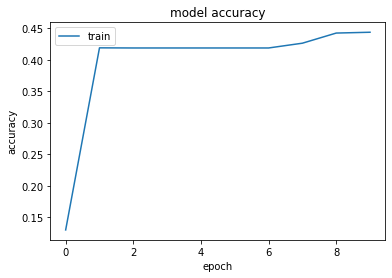

In [ ]:
# The embedding dimension
embedding_dim_Encoder = 60
embedding_dim_Decoder =  300
VOCAB_SIZE_ENCODER = VOCAB_SIZE_DECODER

# Number of RNN units
rnn_units = 100


## Encoder
encode_input = keras.Input(shape=(None,), name="title")
encode_features = layers.Embedding(VOCAB_SIZE_ENCODER, embedding_dim_Encoder)(encode_input) 
encoder = layers.LSTM(rnn_units, return_state=True, name = 'encode')
encode_output, state_h, state_c = encoder(encode_features)

# Estado da celula 
encoder_state = [state_h, state_c]

#layers.Bidirectional

#layers.CuDNNLSTM

## Decoder
decode_input = keras.Input(shape=(None,), name="content")
decode_features = layers.Embedding(VOCAB_SIZE_DECODER, embedding_dim_Decoder)(decode_input)
decode = layers.LSTM(rnn_units, return_state=True, return_sequences=True, name = 'decode')
decode_out, _, _ = decode(decode_features, initial_state = encoder_state)
decoder_outputs = layers.Dense(VOCAB_SIZE_DECODER, activation="softmax")(decode_out)

# Estado da celula 


model = keras.Model([encode_input, decode_input], decoder_outputs)
model.summary()

#keras.backend.clear_session()

#keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

hist = model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss = "categorical_crossentropy",
    metrics = "acc"
)

#class CustomCallback(keras.callbacks.Callback):
#  def on_epoch_end(self, epoch, logs=None):
#    if 0 == epoch%1: 
#        print(f'Época: {epoch} \n output:{logs["predict"]}')
        

history = model.fit([Encoder_Train, Decoder_Train], Target_Train,
          batch_size = 5000,
          validation_split=0.2,
          callbacks=[keras.callbacks.EarlyStopping('loss', min_delta=0.1, patience=3, restore_best_weights=True)],
          epochs=10, verbose=2)


plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
# Predições 
pred = model.predict([Encoder_Test, Decoder_Test])

def deconder_as(pred, num):
  
  nums = [int(u) for u in (np.random.uniform(0, len(Encoder_Test), 3))]
  
  for i in nums:
    print(i)
    preds = tf.random.categorical(pred[i], num_samples=1).numpy()

    enc = tokenizer_Encoder.sequences_to_texts(np.array([ [idx] for idx in tf.squeeze(Encoder_Test[(i):(i+1)])]))
    res = tokenizer_Decoder.sequences_to_texts(preds)
    tgt = tokenizer_Decoder.sequences_to_texts([[idx] for idx in Decoder_Test[i]])
    print(f'Encode: \n>{"".join(enc)}')
    print(f'Previsto:  \n>{" ".join(res)}')
    print(f'Real: \n>{" ".join(tgt)}' )
    print('-------------------\n')
deconder_as(pred,3)


#def generating(title, num_words):
#  words = []
#  # Encoded
#  e_text = tokenizer_Encoder.texts_to_sequences("title")
#
#  encode_output, state_h, state_c = Econder_model(e_text)
#  encoder_state = [state_h, state_c]
#
#  # Decoded
#  decode_input = keras.Input(shape=(None,), name="content")
#  decode_features = layers.Embedding(VOCAB_SIZE_DECODER, embedding_dim_Decoder)(decode_input)
#  decode = layers.LSTM(rnn_units, return_state=True, return_sequences=True, name = 'decode')
#  decode_out, state_h, state_c = decode(decode_features, initial_state = encoder_state)
#
#  decoder_state = [state_h, state_c]
#
#
#  decoder_outputs = layers.Dense(VOCAB_SIZE_DECODER, activation="softmax")(decode_out)
#
#
#
#  decoded_model = keras.Model(decode_input, decode_out)
#  
#  pred = Decoder_model()
#
#  words.append(decode_out)
#  
#  for word in range(num_words):
#
#    decode_out, state_h, state_c = decode(decode_features, initial_state = encoder_state)
#
#    decoder_state = [state_h, state_c]
#
#    words.append(decode_out)

#    decoder_outputs = layers.Dense(VOCAB_SIZE_DECODER, activation="softmax")(decode_out)
#    decoded_model = keras.Model(decode_input, decode_out)




2888
Encode: 
>barra de santos
Previsto:  
>sera quando que em luz estar janeiro pelas palavras ali hoje ja en outro nosso en ti que em outro <OOV> is aqui olhar nao azul oh es and vezes
Real: 
 e a tarde <OOV> <OOV>
-------------------

1980
Encode: 
>comer cu, chupar bocetatem
Previsto:  
 na pelas me amar in minhas
Real: 
 no <OOV> da <OOV> enquanto <OOV> <OOV> outros <OOV> entre a mulher e o <OOV> quem mais <OOV> tem <OOV> o <OOV> e uma <OOV> que nao
-------------------

1752
Encode: 
>num zoologico de letras
Previsto:  
>the vao pode oh sao melhor olhos por ali los my outro tal esta todo ar sonho the pag desejo <OOV> no ser belo sob longe versos dor manha sob
Real: 
>bos <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
-------------------

